<h1>Analiza zbioru danych German credit data<h1/>

German credit data to zbiór danych zawierający informacje o osobach, które chcą zaciągnąć kredyt. Osoby są klasyfikowane jako good/bad, co ma odzwierciedlać czy udzielenie im pożyczki stanowi ryzyko dla banku. W przypadku klasyfikacji jako "good" osoba najprawdopodobniej wywiąże się z zobowiązania.  

Dane pochodzą z końca zeszłego wieku. Ich analiza nie będzie zatem reprezentatywna dla współczesności, może nam dać jedynie pogląd na to, jakie czynniki ogólnie mają wpływ na taki scoring.

  
 Tabela zawiera 21 kolumn, z których każda może mieć potencjalny wpływ na scoring. Są to takie zmienne jak: wiek kredytobiorcy, status cywilny (z informacją o płci), kwota kredytu, czas jego spłaty oraz cel, na który kredyt jest zaciągany.  
 W swojej analizie nie zamierzam badać wpływu wszystkich zmiennych, ale spróbuję ustalić, które czynniki mają największy wpływ na scoring. Przyjrzę się również różnicom w kwestii zaciągania kredytów przez kobiety i mężczyzn. 



<h2>Przygotowanie i przegląd danych<h2/>

In [189]:
#wczytanie bibliotek
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, roc_auc_score
import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns


In [190]:
#wczytanie pliku
df = pd.read_csv('german_credit_data.csv',sep=';')

In [191]:
#uporządkowanie indeksu, dopilnowanie, aby była tylko jedna kolumna indeksowa
df.reset_index(inplace=True)
df.set_index('index', inplace=True)

In [192]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
index,,,,,,,,,,,,,,,,,,,,,
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [193]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

Widzimy, że mamy do czynienia z 1000 rekordami. Jeśli chodzi o typ danych, to mamy obiekty i liczby. Na pierwszy rzut oka, kolumny zawierające liczby mają odpowiednie typy.

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

Statystyki dla kolumn zawierających wartości numeryczne. Widzimy np., że średnim czasem, na który zaciągano kredyt było 20 miesięcy (zakładam, że z taką jednostką czasu mamy tu do czynienia), a mediana to 18 miesięcy. Najdłuższym okresem są tu 72 miesiące. Może być to wartość odstająca, ponieważ wartość na przecięciu 75% jest dużo niższa (24 miesiące).  
Jeśli chodzi o kwoty kredytu, to średnia wartość to ok. 3200 (EUR?). Jest tu bardzo duża różnica między kwotą najmniejszą a największą (najmniejsza to 250, a największa ponad 18000).  
Inną interesującą kolumną jest wiek - średni wiek osób zaciągających kredyt to 35,5 roku. Mamy również dużą różnicę między osobą najmłodszą a najstarszą (19 vs 75 lat).  


In [195]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [196]:
#Sprawdzenie, czy w tabeli są nulle - nie ma.
df.isnull().values.any()

False

Ogólne sprawdzenie korelacji między zmiennymi numerycznymi.

In [197]:
labels_x = ['duration','credit_amount','installment_commitment', 'residence_since','age','existing_credits','num_dependents', 'foreign_worker']
correlation_matrix = df[labels_x].corr()
correlation_matrix

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
duration,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834
credit_amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142
installment_commitment,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207
residence_since,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643
age,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201
existing_credits,-0.011284,0.020795,0.021669,0.089625,0.149254,1.000000,0.109667
num_dependents,-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.000000


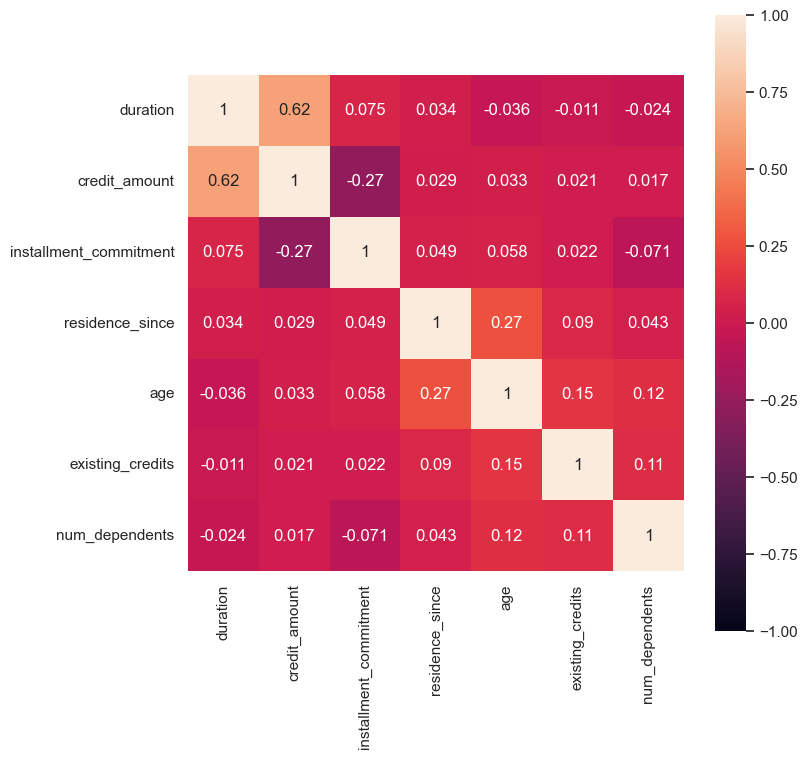

In [267]:
sns.set(rc={'figure.figsize':(8,8)}) 

sns.heatmap(
    correlation_matrix,
    vmin=-1.,
    vmax=1., 
    square=True,
    annot=True) 
pass

W zbiorze nie mamy do czynienia z silną korelacją między żadnymi ze zmiennych. Najwyższą korelację obserwujemy między czasem trwania umowy kredytowej a jego kwotą. Nie jest to zaskakujące - wyższe kredyty spłacamy zazwyczaj dłużej i na odwrót. Korelacja między nimi jest całkiem spora - 0.62. Od ok. 0.75 mówilibyśmy o wysokiej pozytywnej korelacji i konieczne mogłoby być usunięcie jednej ze zmiennych skorelowanych.

<h2>Eksploracyjna analiza danych<h2/>

Widzimy, ze aż 700 na 1000 osób dostało scoring "good", co daje nam 70%

In [199]:
df['class'].value_counts()

good    700
bad     300
Name: class, dtype: int64

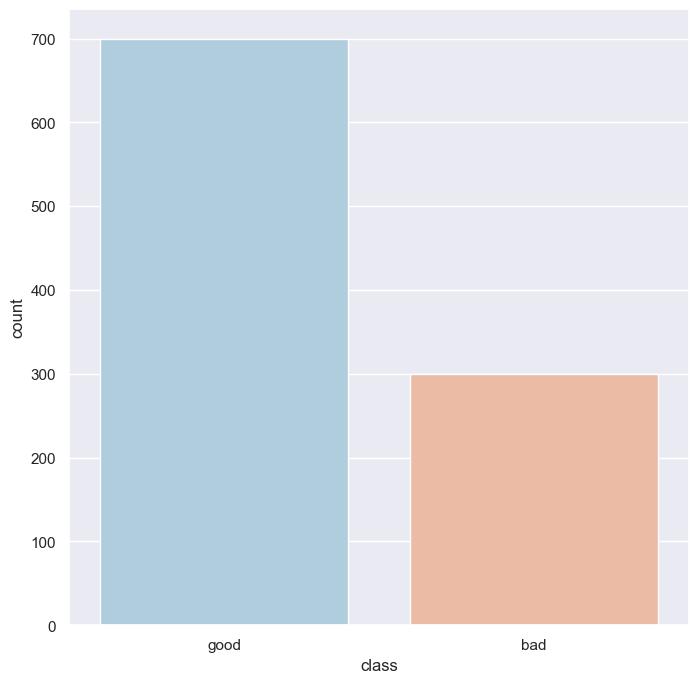

In [200]:
sns.countplot(x='class', data=df, palette='RdBu_r');

<h3>Cel kredytu<h3/>

Na jakie cele zaciągano kredyty? Co ciekawe króluje radio/tv, dopiero na drugim miejscu jest nowy samochód (jednak sumując kategorie "nowy samochód" i "stary samochód", samochód wysuwa się na pierwsze miejsce). Wynika to najpewniej z tego, że zbiór danych zawiera dane o kredytach na stosunkowo małe kwoty

In [201]:
df['purpose'].unique()

array(['radio/tv', 'education', 'furniture/equipment', 'new car',
       'used car', 'business', 'domestic appliance', 'repairs', 'other',
       'retraining'], dtype=object)

In [202]:
df['purpose'].value_counts().to_frame()

,purpose
radio/tv,280
new car,234
furniture/equipment,181
used car,103
business,97
education,50
repairs,22
domestic appliance,12
other,12
retraining,9


Jak to wygląda dla osób ze scoringiem good i bad?

In [268]:
purpgood = df[df['class']=='good']['purpose'].value_counts().to_frame()
purpbad = df[df['class']=='bad']['purpose'].value_counts().to_frame()


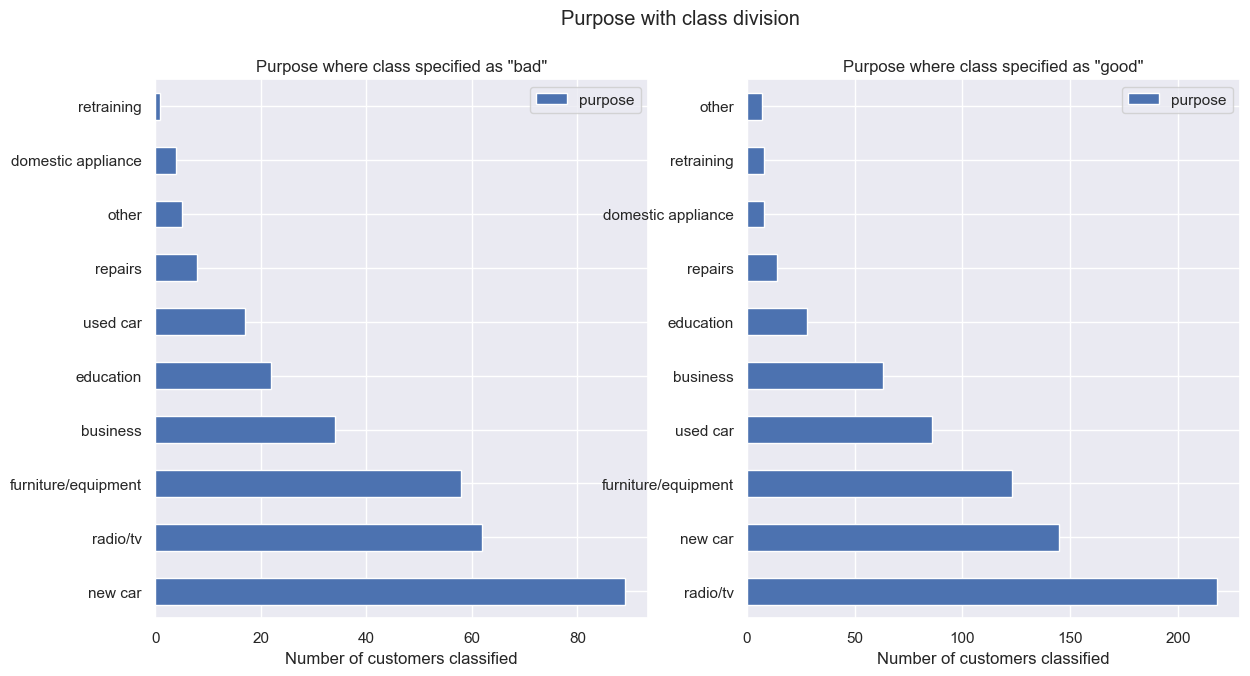

In [270]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,7))

purpbad.plot(kind='barh',ax = axes[0], subplots=True)
axes[0].set_title('Purpose where class specified as "bad"')
axes[0].set_xlabel('Number of customers classified')
plt.xlabel('Number of customers classified')
plt.suptitle('Purpose with class division')
plt.style.use('seaborn-deep')
purpgood.plot(kind='barh',ax = axes[1], subplots=True)
axes[1].set_title('Purpose where class specified as "good"')
axes[1].set_xlabel('Number of customers classified')

plt.show()

Na powyższych wykresach widzimy, że najczęściej kredyty na samochód uznawano za ryzykowne - zapewne w związku z dużą kwotą. Najwięcej osób, które dostało pozytywny scoring, chciało kupić nowy telewizor lub radio, czyli przedmioty stosunkowo tanie.

<h3>Czas trwania kredytu<h3/>

Jak widać na poniższym wykresie, najczęściej umowy kredytowe zawierano na okres do 25 miesięcy, dużo rzadziej na dłuższe okresy. Wiąże się to najpewniej z niskimi kwotami, na które opiewały kredyty.

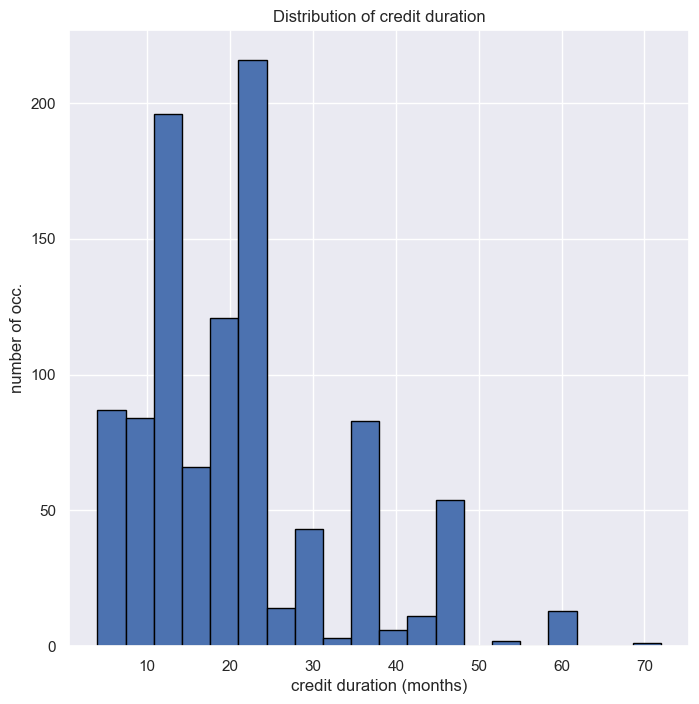

In [206]:
plt.hist(
    df['duration'],
    edgecolor="black",
    bins=20
)
plt.xlabel("credit duration (months)")
plt.ylabel("number of occ.")
plt.title('Distribution of credit duration')
plt.show()

In [207]:
long = df[df['duration']>30]
long['class'].value_counts().to_frame()

,class
good,90
bad,83


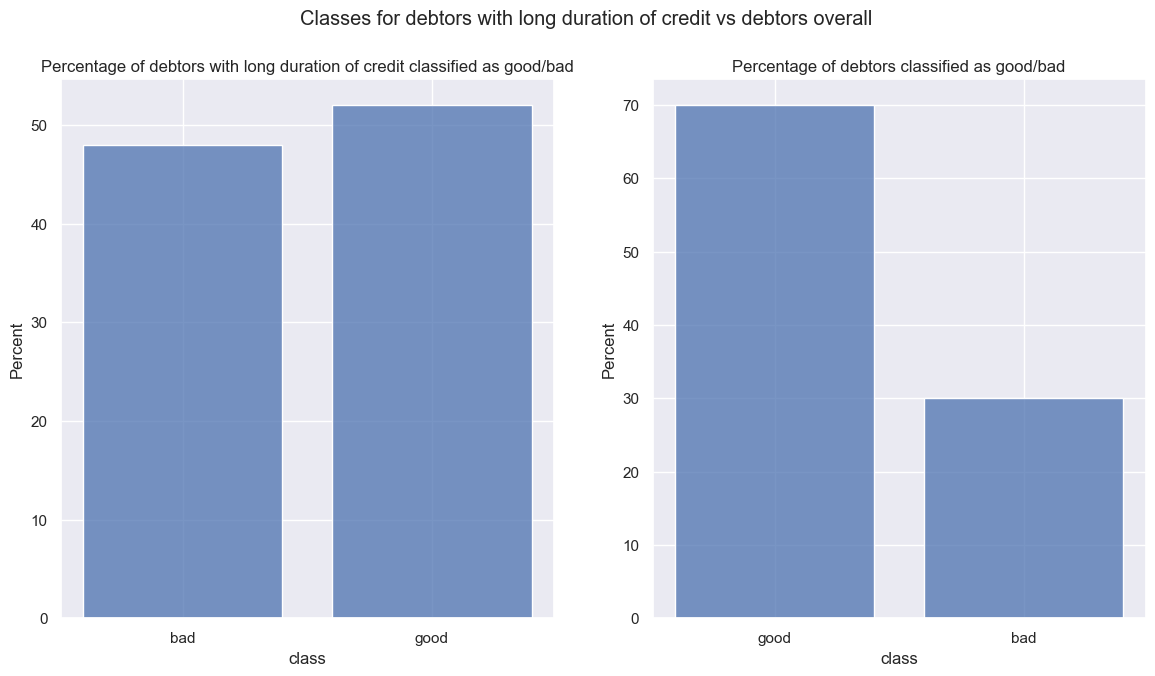

In [208]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with long duration of credit vs debtors overall')
axes[0].set_title('Percentage of debtors with long duration of credit classified as good/bad')
sns.histplot(x='class', data=long, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[1])
plt.style.use('seaborn-deep')
plt.show()

Jak widzimy na powyższym wykresie, dla osób, które chciały zaciągnąć kredyt na okres powyżej 30 miesięcy, scoringi są niemal wyrównane, co znacznie odbiega od średniej. Prawie 50% osób w tej kategorii zostało sklasyfikowana jako "bad". Oznacza to, że okres trwania umowy kredytowej ma bardzo duży wpływ na scoring.

<h3>Własna nieruchomość<h3/>

Czy ma znaczenie to, czy osoba zaciągajaca kredyt ma własną nieruchomość?

In [209]:
df.housing.value_counts().to_frame()

,housing
own,713
rent,179
for free,108


In [210]:
hasown = df[df['housing']=='own']
hasown['class'].value_counts().to_frame()

,class
good,527
bad,186


Jak widać na poniższym wykresie, posiadanie własnej nieruchomości nie ma dużego wpływu na scoring, jest to różnica o dosłownie kilka punktów procentowych.

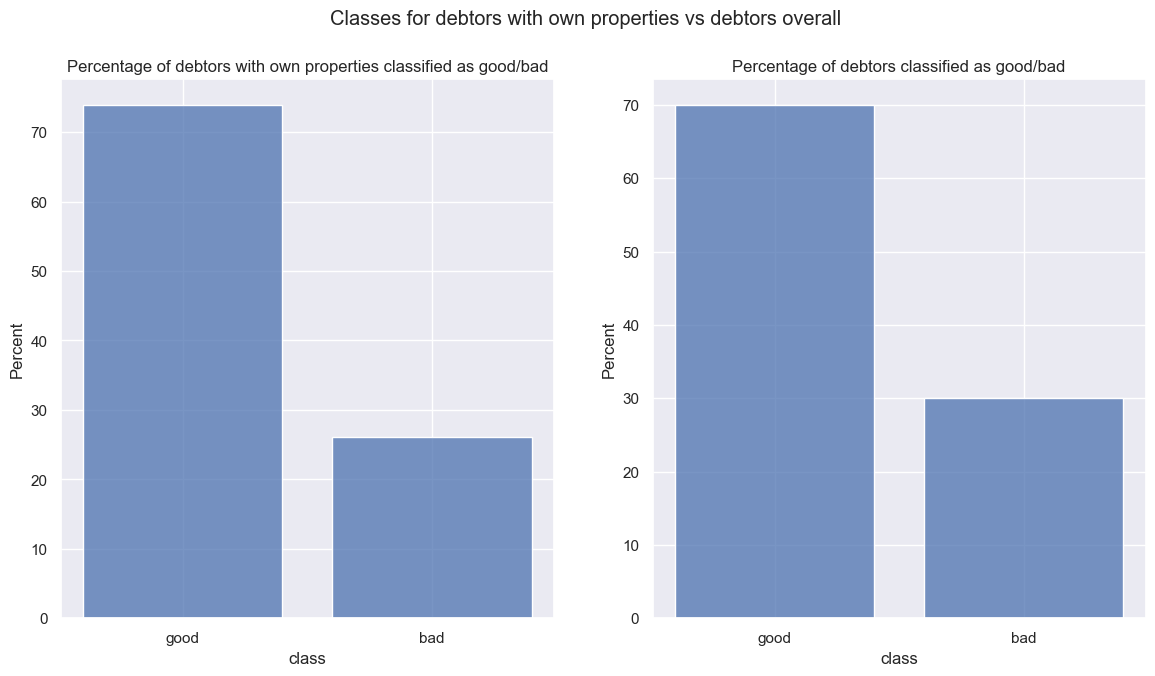

In [211]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with own properties vs debtors overall')
axes[0].set_title('Percentage of debtors with own properties classified as good/bad')
sns.histplot(x='class', data=hasown, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[1])
plt.style.use('seaborn-deep')
plt.show()

<h3>Zatrudnienie<h3/>

W tabeli uwzględniono również informacje o tym, czy osoba jest wykwalifikowanym pracownikiem lub osobą bezrobotną. Wydaje się, że jest to informacja, która będzie miała mocny wpływ na scoring.

In [212]:
df.job.value_counts().to_frame()

,job
skilled,630
unskilled resident,200
high qualif/self emp/mgmt,148
unemp/unskilled non res,22


Liczba osób wykwalifikowanych i wysoko wykwalifikowanych, podział na scoring:

In [213]:
qualjob = df[(df['job']=='skilled') | (df['job']=='high qualif/self emp/mgmt')]
qualjob['class'].value_counts().to_frame()


,class
good,541
bad,237


Liczba osób niewykwalifikowanych/bez pozwolenia na pobyt, podział na scoring:

In [214]:
nonqual = df[(df['job']=='unskilled resident') | (df['job']=='unemp/unskilled non res')]
nonqual['class'].value_counts().to_frame()

,class
good,159
bad,63


Co zaskakujące, różnica jest tutaj jeszcze mniejsza niż w przypadku posiadania własnej nieruchomości. Niemalże nie ma znaczenia, czy osoba jest wykwalifikowanych pracownikiem.

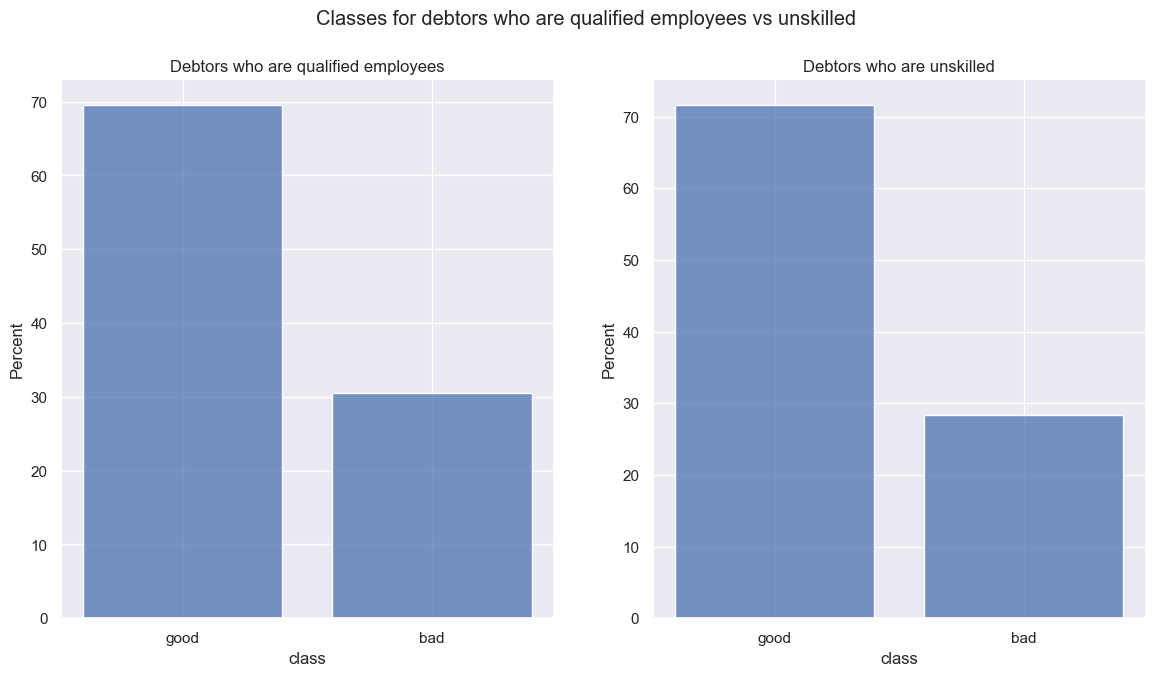

In [215]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors who are qualified employees vs unskilled')
axes[0].set_title('Debtors who are qualified employees')
sns.histplot(x='class', data=qualjob, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Debtors who are unskilled')
sns.histplot(x='class', data=nonqual, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[1])
plt.style.use('seaborn-deep')
plt.show()

W związku z tym nasuwa się pytanie, czy osoby bezrobotne są tak samo oceniane, czy jednak brak pracy ma tu duży wpływ na scoring.

In [216]:
df[df['employment']=='unemployed']['class'].value_counts().to_frame()

,class
good,39
bad,23


In [217]:
nowork = df[df['employment']=='unemployed']


W przypadku osób bezrobotnych widzimy już większą różnicę względem całości danych. Prawie 40% osób bezrobotnych dostało scoring negatywny, gdzie w przypadku ogółu jest to 30%.

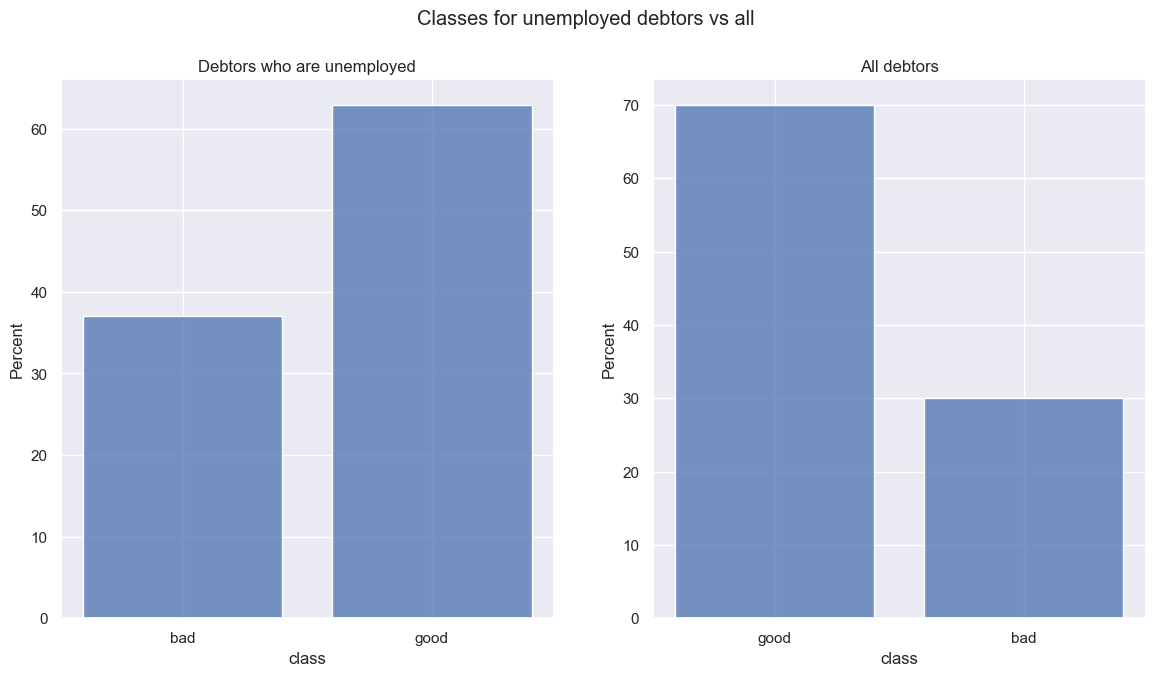

In [218]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for unemployed debtors vs all')
axes[0].set_title('Debtors who are unemployed')
sns.histplot(x='class', data=nowork, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('All debtors')
sns.histplot(x='class', data=df, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[1])
plt.style.use('seaborn-deep')
plt.show()

Kolumną, która daje nam ciekawy ogląd na całość danych jest kolumna "foreign worker". Okazuje się, że znaczna większość rekordów dotyczy pracowników zagranicznych, a nie rodowitych Niemców.

In [219]:
df['foreign_worker'].value_counts().to_frame()

,foreign_worker
yes,963
no,37


W związku z tym, że przy filtrowaniu na osoby sklasyfikowane jako "foreign worker" mamy do czynienia z większością rekordów, wyniki scoringu są reprezentatywne na całość (nie odbiegają od średnich dla całego zbioru).

In [220]:
df[df['foreign_worker']=='yes']['class'].value_counts().to_frame()

,class
good,667
bad,296


Inaczej jest, gdy filtrujemy na osoby, które nie są zagranicznymi pracownikami. Silnie wskazują one na lepszy scoring takich osób.

In [221]:
df[df['foreign_worker']=='no']['class'].value_counts().to_frame()

,class
good,33
bad,4


<h3>Analiza z podziałem na płeć<h3/>

Fakt, że w statusie cywilnym została uwzględniona płeć, umożliwia nam analizę pod kątem tego jakimi kredytobiorcami są kobiety i mężczyźni. Przy takiej analizie należy pamiętać, że mamy do czynienia ze starymi danymi, dlatego dużo większy udział mężczyzn niż kobiet nie powinien dziwić, w związku z tym, że kobiety były rzadziej niezależne finansowo w latach 90. niż obecnie.

In [222]:
df['personal_status'].unique()

array(['male single', 'female div/dep/mar', 'male div/sep',
       'male mar/wid'], dtype=object)

Warto zwrócić uwagę na to, że jedyne kobiety, które zaciągają tutaj kredyty, to mężątki/rozwódki. W przypadku mężczyzn mamy dużo większy wachlarz opcji, w tym singla.

In [223]:
female = df[df['personal_status'].str.contains('female')]
male = df[~df['personal_status'].str.contains('fe')]

In [224]:
sexc = pd.DataFrame({
    'sex': ['female','male'],
    'count': [len(female), len(male)]
})

In [225]:
sexc

,sex,count
0,female,310
1,male,690


Zgodnie z oczekiwaniami, ponad dwa razy więcej kredytobiorców to mężczyźni.

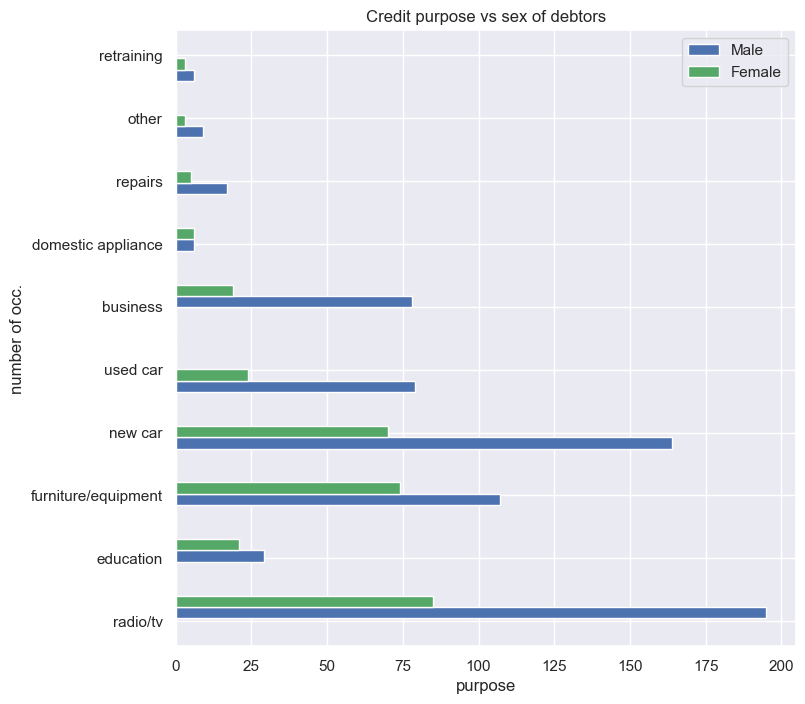

In [226]:
plt.style.use('seaborn-deep')
plt.hist(
    [male['purpose'], female['purpose']],
    bins=20,
    orientation='horizontal'
)
plt.xlabel("purpose")
plt.ylabel("number of occ.")
plt.legend(['Male','Female'],loc='upper right')
plt.title('Credit purpose vs sex of debtors')
plt.show()

Zarówno kobiety jak i mężczyźni najczęściej zaciągali kredyty na radio/telewizor. Co ciekawe, u kobiet drugim najczęstszym celem są meble/wyposażenie, a u mężczyzn nowy samochód.

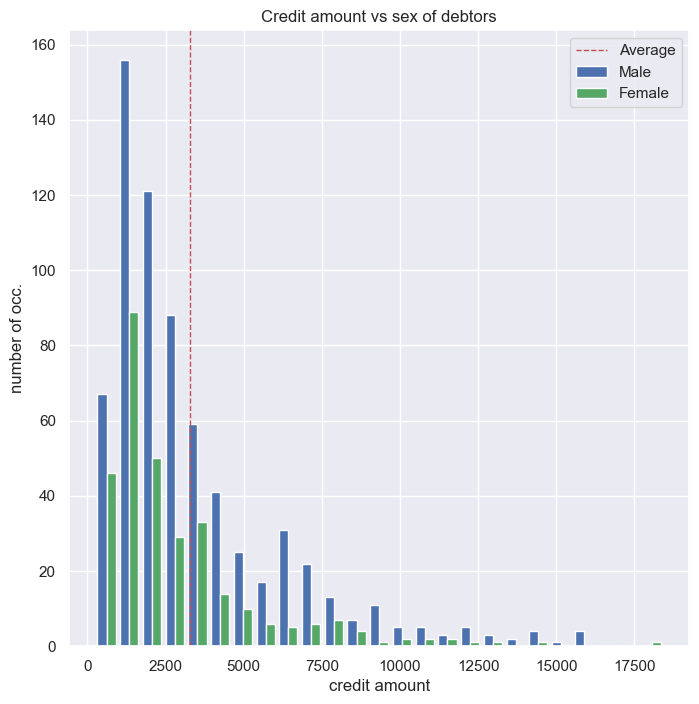

In [227]:
plt.style.use('seaborn-deep')
plt.hist(
    [male['credit_amount'], female['credit_amount']],
    bins=25,
)
plt.xlabel("credit amount")
plt.axvline(df['credit_amount'].mean(), color='r', linestyle='dashed',linewidth=1, label='Average')
plt.ylabel("number of occ.")
plt.legend(['Average','Male','Female'],loc='upper right')
plt.title('Credit amount vs sex of debtors')
plt.show()

Jak widać na powyższym jednomodalnym wykresie (rozkład prawoskośny), znaczna większość kredytów opiewa na niewielkie sumy poniżej 2000 euro. Zarówno dla kobiet jak i mężczyzn jest niewiele kredytów na wysokie kwoty. Co ciekawe, wartość odstająca, czyli kredyt na kwotę powyżej 17000 euro, został zaciągnięty przez kobietę. 

In [228]:
expens = df[df['credit_amount']>5000]
expens['class'].value_counts().to_frame()

,class
good,110
bad,78


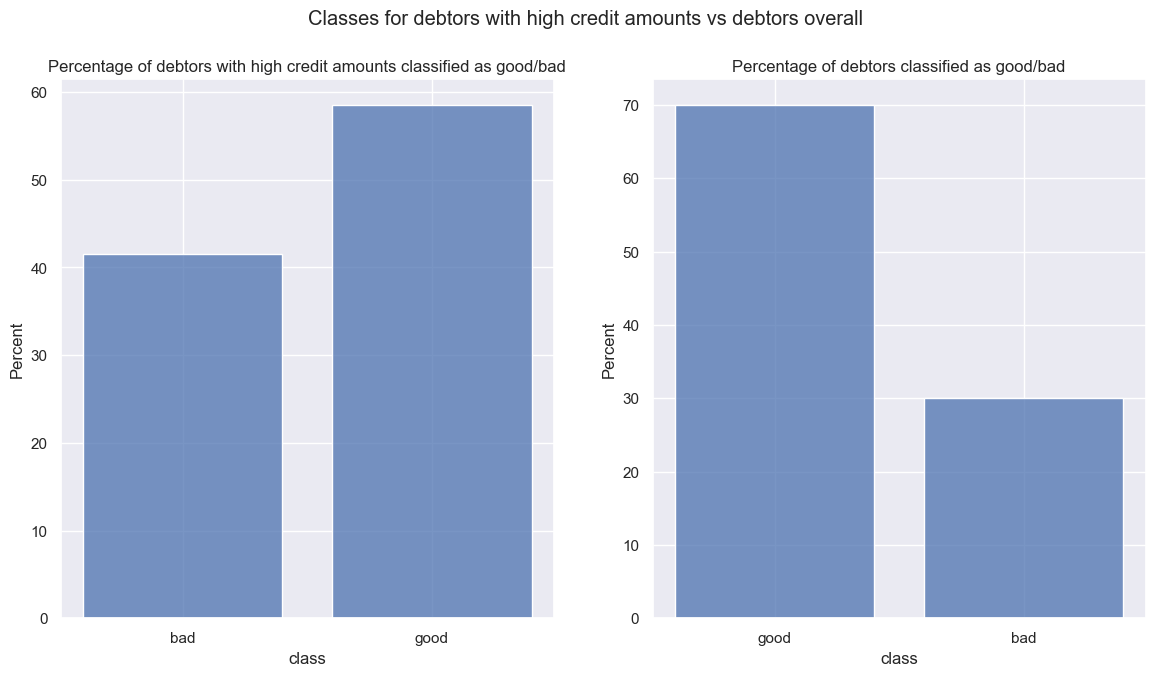

In [229]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with high credit amounts vs debtors overall')
axes[0].set_title('Percentage of debtors with high credit amounts classified as good/bad')
sns.histplot(x='class', data=expens, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[1])
plt.style.use('seaborn-deep')
plt.show()

Jak widzimy na powyższym wykresie, kwota kredytu ma również wpływ na scoring - dla osób chcących zaciągnąć kredyt na kwotę powyżej 5000 euro, scoring jest dużo mniej łaskawy niż dla całości (różnica ponad 10 punktów procentowych).

Jak z kolei wygląda sytuacja klasyfikacji mężczyzn i kobiet pod względem ryzyka kredytowego?

In [230]:
femclass = pd.pivot_table(female,index='class',values='purpose', aggfunc=len)
femclass.reset_index(inplace=True)
femclass = femclass.rename(columns={'purpose':'female'})
femclass

,class,female
0,bad,109
1,good,201


In [231]:
maleclass = pd.pivot_table(male,index='class',values='purpose', aggfunc=len)
maleclass.reset_index(inplace=True)
maleclass = maleclass.rename(columns={'purpose':'male'})
maleclass

,class,male
0,bad,191
1,good,499


Jak widać w poniższej tabelce, procentowo więcej kobiet uzyskało scoring "bad". Różnica jest dosyć znaczna - o prawie 8 punktów procentowych.

In [232]:
totalclass = femclass.merge(maleclass, how='outer', on = 'class')

totalclass['female %'] = totalclass['female'] / totalclass['female'].sum()*100
totalclass['male %'] = totalclass['male'] / totalclass['male'].sum()*100
totalclass = totalclass.round(2)
totalclass


,class,female,male,female %,male %
0,bad,109,191,35.16,27.68
1,good,201,499,64.84,72.32


In [271]:
toplot = totalclass.drop(['female','male'], axis=1)


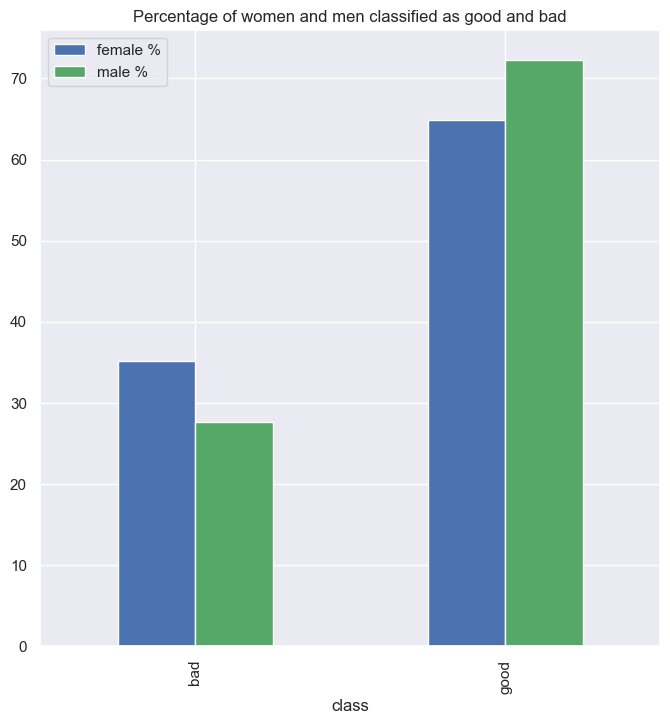

In [234]:
toplot.plot(kind='bar',x='class')
plt.title('Percentage of women and men classified as good and bad')
plt.show()

Jeśli chodzi o wiek kobiet i mężczyzn zaciągających kredyty, to nie widać znacznych różnic. Można zwrócić uwagę na to, że największe zagęszczenie punktów mamy ok. 30 r. ż., dla kobiet nawet poniżej 30 r. ż.

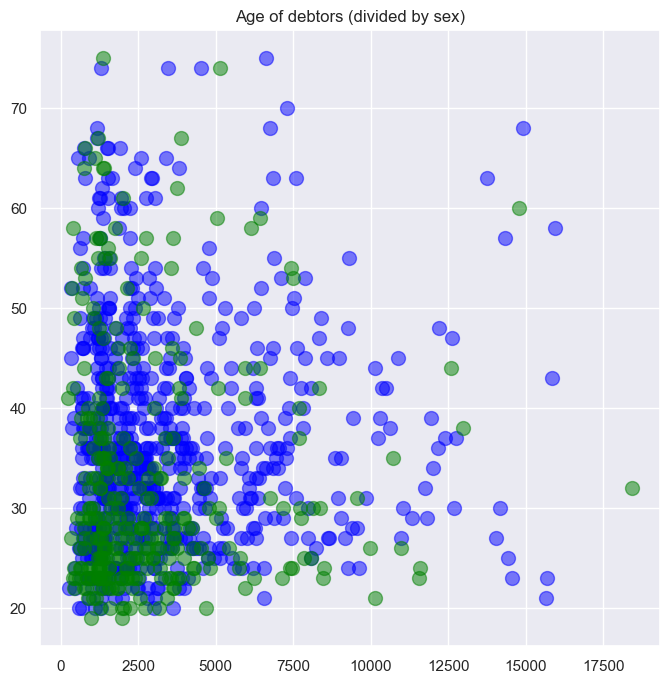

In [235]:
plt.scatter(male['credit_amount'], male['age'], s=100, color='blue', alpha=0.5)
plt.scatter(female['credit_amount'], female['age'], s=100, color='green', alpha=0.5)
plt.title('Age of debtors (divided by sex)')
plt.show()

In [236]:
young = df[df['age']<30]
young['class'].value_counts().to_frame()

,class
good,234
bad,137


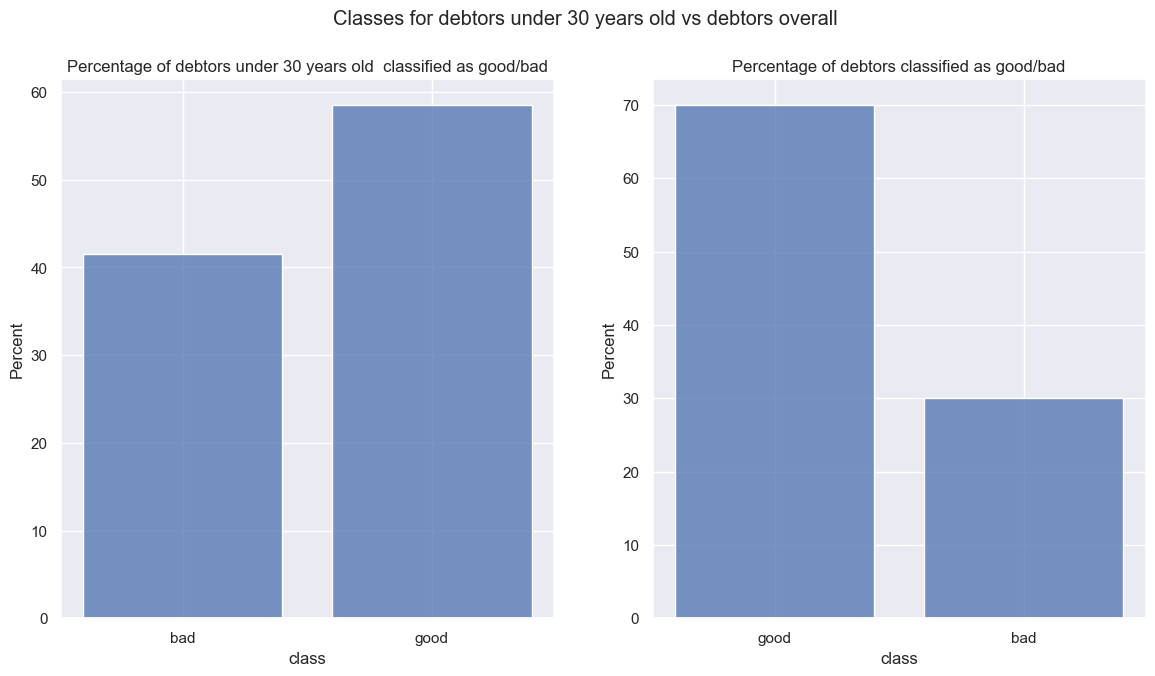

In [237]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors under 30 years old vs debtors overall')
axes[0].set_title('Percentage of debtors under 30 years old  classified as good/bad')
sns.histplot(x='class', data=expens, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, palette='RdBu_r', stat='percent', shrink=0.8, ax=axes[1])
plt.style.use('seaborn-deep')
plt.show()

Na podstawie powyższego wykresu możemy wywnioskować, że wiek ma wpływ na scoring - np. osoby poniżej 30 roku życia częściej są klasyfikowane jako "bad".

Widzimy, że wiele czynników miało wpływ na naszą zmienną celu, czyli klasę (scoring). Wśród przeważających czynników możemy wyróżnić kwotę kredytu, czas trwania kredytu, płeć i wiek. Tych zmiennych użyję do modelowania.

<h3>Przygotowanie danych do modelowania<h3/>

Do modeli będę na pewno potrzebowała kolumny zawierającej płeć. Najpierw zamieniam je w taki sposób, aby były tylko dwie różne kategorie (chcę zastosować label encoder, żeby przećwiczyć jego działanie).

In [238]:
df['personal_status'].unique()

array(['male single', 'female div/dep/mar', 'male div/sep',
       'male mar/wid'], dtype=object)

In [239]:
#zamiana stanu cywilnego mężczyzn na "male"
df.loc[df['personal_status'] == 'male single', 'personal_status'] = 'male'
df.loc[df['personal_status'] == 'male div/sep', 'personal_status'] = 'male'
df.loc[df['personal_status'] == 'male mar/wid', 'personal_status'] = 'male'

In [240]:
#zamiana stanu cywilnego kobiet na "female"
df.loc[df['personal_status'] == 'female div/dep/mar', 'personal_status'] = 'female'

In [241]:
#utworzenie instancji label encodera
labelencoder = LabelEncoder()
#zamiana płci na wartości binarnej i przechowanie wyniku w nowej kolumnie
df['sex'] = labelencoder.fit_transform(df['personal_status'])

Zamieniamy również klasę na wartości binarne

In [242]:
df['Class'] = labelencoder.fit_transform(df['class'])

Zamiana kolumny foreign_worker na wartości binarne (ostatecznie zmienna nie została wykorzystana)

In [243]:
df['Foreign_worker'] = labelencoder.fit_transform(df['foreign_worker'])

In [244]:
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,sex,Class,Foreign_worker
index,,,,,,,,,,,,,,,,,,,,,
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male,none,...,own,2,skilled,1,yes,yes,good,1,1,1
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female,none,...,own,1,skilled,1,none,yes,bad,0,0,1
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male,none,...,own,1,unskilled resident,2,none,yes,good,1,1,1
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male,guarantor,...,for free,1,skilled,2,none,yes,good,1,1,1
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male,none,...,for free,2,skilled,2,none,yes,bad,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female,none,...,own,1,unskilled resident,1,none,yes,good,0,1,1
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male,none,...,own,1,high qualif/self emp/mgmt,1,yes,yes,good,1,1,1
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male,none,...,own,1,skilled,1,none,yes,good,1,1,1


<h3>Modelowanie regresji logistycznej<h3/>

Najpierw próbowałam stworzyć model oparty na samej płci jako X, ale model miał bardzo słabe wyniki i był słabo zbalansowany - nie radził sobie zupełnie w predykcji klasyfikacji jako "bad". Nawet mimo dodania parametru "balanced", wyniki były słabe, a krzywa ROC nie miała żadnej wartości predykcyjnej, przypominała prostą linię.  Dlatego postanowiłam zbudować model oparty na kolumnach numerycznych, które mogą potencjalnie mieć wpływ na scoring - okres kredytu, kwotę kredytu, płeć i wiek. Uważam, że te kolumny dają nam już dosyć dokładny obraz na scoring i są to czynniki najistotniejsze. Jak wykazała moja wcześniejsza analiza, czynniki takie jak zatrudnienie lub to, czy osoba ma własną nieruchomość, nie mają dużego wpływu na scoring. Również cel kredytu wydaje się być zmienną powiązaną z kwotą kredytu, która będzie tu miała większe znaczenie. Dlatego postanowiłam nie zamieniać wszystkich kolumn i nie uwzględniać ich w modelowaniu. (Sprawdziłam również model dla wszystkich kolumn numerycznych i wynik był nieznacznie gorszy, dlatego postanowiłam uwzględnić tylko wybrane zmienne)

In [245]:
labels_col = ['duration','credit_amount', 'age', 'sex']
X = np.array(df[labels_col])
y = np.array(df['Class'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=10, test_size=0.2
)
#manipulowałam parametrem test_size i najlepsze wyniki na teście i trainei uzyskiwane są tutaj właśnie przy test_size=0.2.


In [246]:
model = LogisticRegression(random_state=10, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [247]:
model.score(X_train, y_train)

0.70625

In [248]:
model.score(X_test, y_test)

0.73

In [249]:
y_pred = model.predict(X_test)

In [250]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

W wartościach predykowanych widzimy znaczną przewagę klasy 1, czyli "good". Już nasuwa to podejrzenie, że model będzie dużo lepiej radził sobie z klasyfikacją tej klasy niż klasy 0.

Krzywa ROC i roc_auc_score  wskazują raczej na przeciętny charakter modelu. Krzywa ROC idzie dosyć mocno w stronę lewego rogu, w którym mielibyśmy do czynienia z udaną predykcją. Wartość wskazuje na ok. 77% auc_score, czyli model można uznać za całkiem dobry.

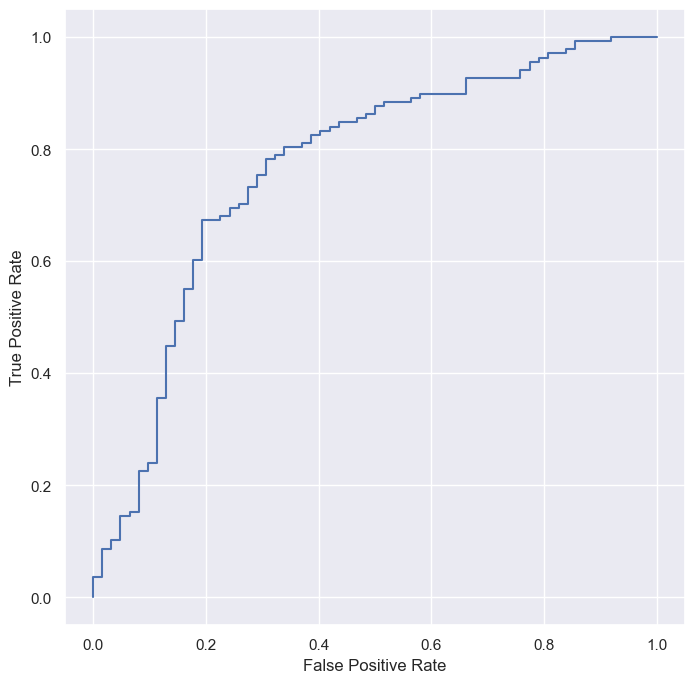

In [253]:

pred_test_proba = model.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, pred_test_proba)
roc_display = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test).plot()

In [254]:
roc_auc_score(y_test, pred_test_proba)

0.7658952781673679

Jak widzimy na poniższej macierzy pomyłek, model dosyć dobrze poradził sobie z poprawnym sklasyfikowaniem klasy 0. Jednak aż 53 razy sklasyfikował niepoprawnie klasę jako "good", czyli nadmiernie ocenia wartości jako 1. Precyzja dla klasy 1 jest stosunkowo niska (72%), co wskazuje na pewne przestrzelenie klasy pozytywnej. 
   
Accuracy całego modelu to 73%. Nie wydaje mi się to być bardzo dobrym wynikiem. Problemy tego modelu wynikają najprawdopodobniej z tego, że klasy są źle zbalansowane, są w stosunku 3:7, różnica między nimi powinna zapewne być mniejsza - model ma za mało danych, żeby uczyć się poprawnie przypisywać dane do tej mniej licznej klasy.  
Co ciekawe, jak dodałam do modelu na próbę kolumnę "foreign_worker", to wynik modelu pogorszył się (nie bardzo, accuracy spadło o 1%, ale różnica była). Wydaje mi się, że wynika to z tego, że ta kolumna była bardzo źle zbilansowana - większość osób była sklasyfikowana jako foreign_worker, a osoby, które miały tam "nie", miały w znacznej większości pozytywny scoring.

              precision    recall  f1-score   support

           0       0.90      0.15      0.25        62
           1       0.72      0.99      0.84       138

    accuracy                           0.73       200
   macro avg       0.81      0.57      0.54       200
weighted avg       0.78      0.73      0.65       200



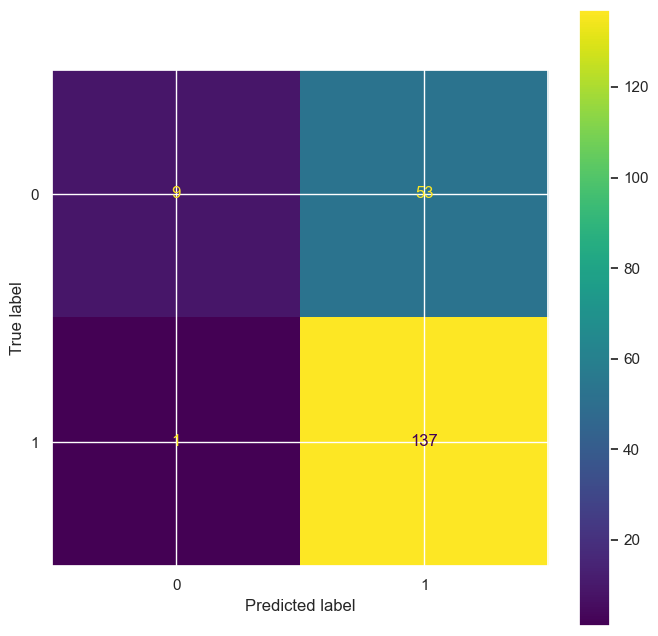

In [255]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(classification_report(y_test, y_pred))

In [256]:

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.73
Precision: 0.7210526315789474
Recall: 0.9927536231884058


<h3>Modelowanie drzewa decyzyjnego<h3/>

In [257]:
#utworzenie instancji drzewa decyzyjnego i podział danych na testowe i treningowe
tree_clf = DecisionTreeClassifier(random_state=100, criterion='gini')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=100, test_size=0.25
    )

In [258]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=100)

W przypadku drzewa decyzyjnego widzimy tutaj zdecydowany overfitting = model ma 100% accuracy na zbiorze testowym i ok. 60% na zbiorze testowym.

In [259]:
print("Accuracy on training set: {:.2f}".format(tree_clf.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(tree_clf.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.59


Drzewo jest wielkie i nieczytelne, aż prosi się o przycięcie.

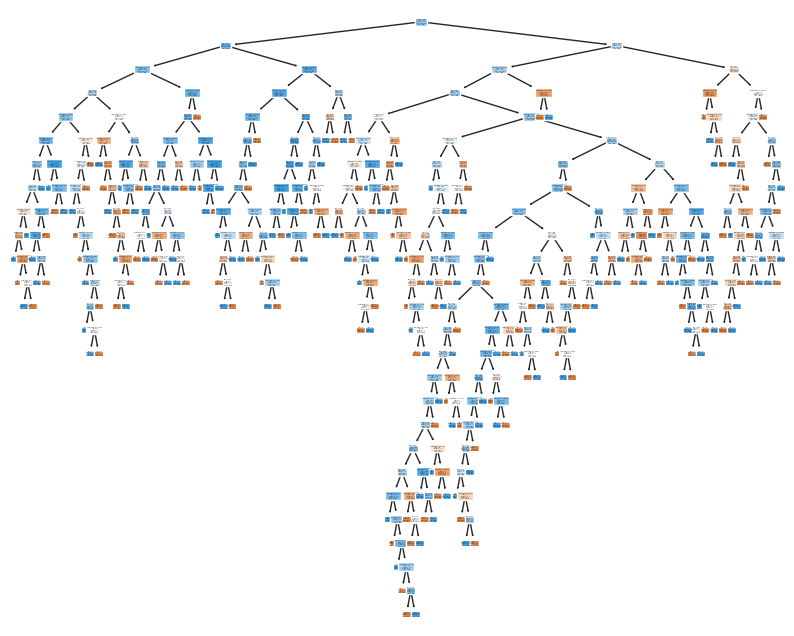

In [260]:
plt.figure(figsize=(10,8))

plot_tree(tree_clf, feature_names=labels_col, class_names=df['class'].values, filled=True);

Dopasowałam parametry metodą prób i błędów. Próbowałam zastosować random search, ale podsuwał mi parametry dające lekko gorsze accuracy.

In [261]:
tree_clf2 = DecisionTreeClassifier(max_depth=4,
                                   random_state=100, max_features=3,max_leaf_nodes=20,
                                   min_samples_leaf = 10, criterion='gini')
tree_clf2.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(tree_clf2.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(tree_clf2.score(X_test, y_test)))

Accuracy on training set: 0.72
Accuracy on test set: 0.69


Ograniczenie głębokości drzewa do 4 poziomów i manipulowanie innymi parametrami pomogło zniwelować overfitting. Accuracy przypomina wynik, który uzyskaliśmy przy regresji logistycznej

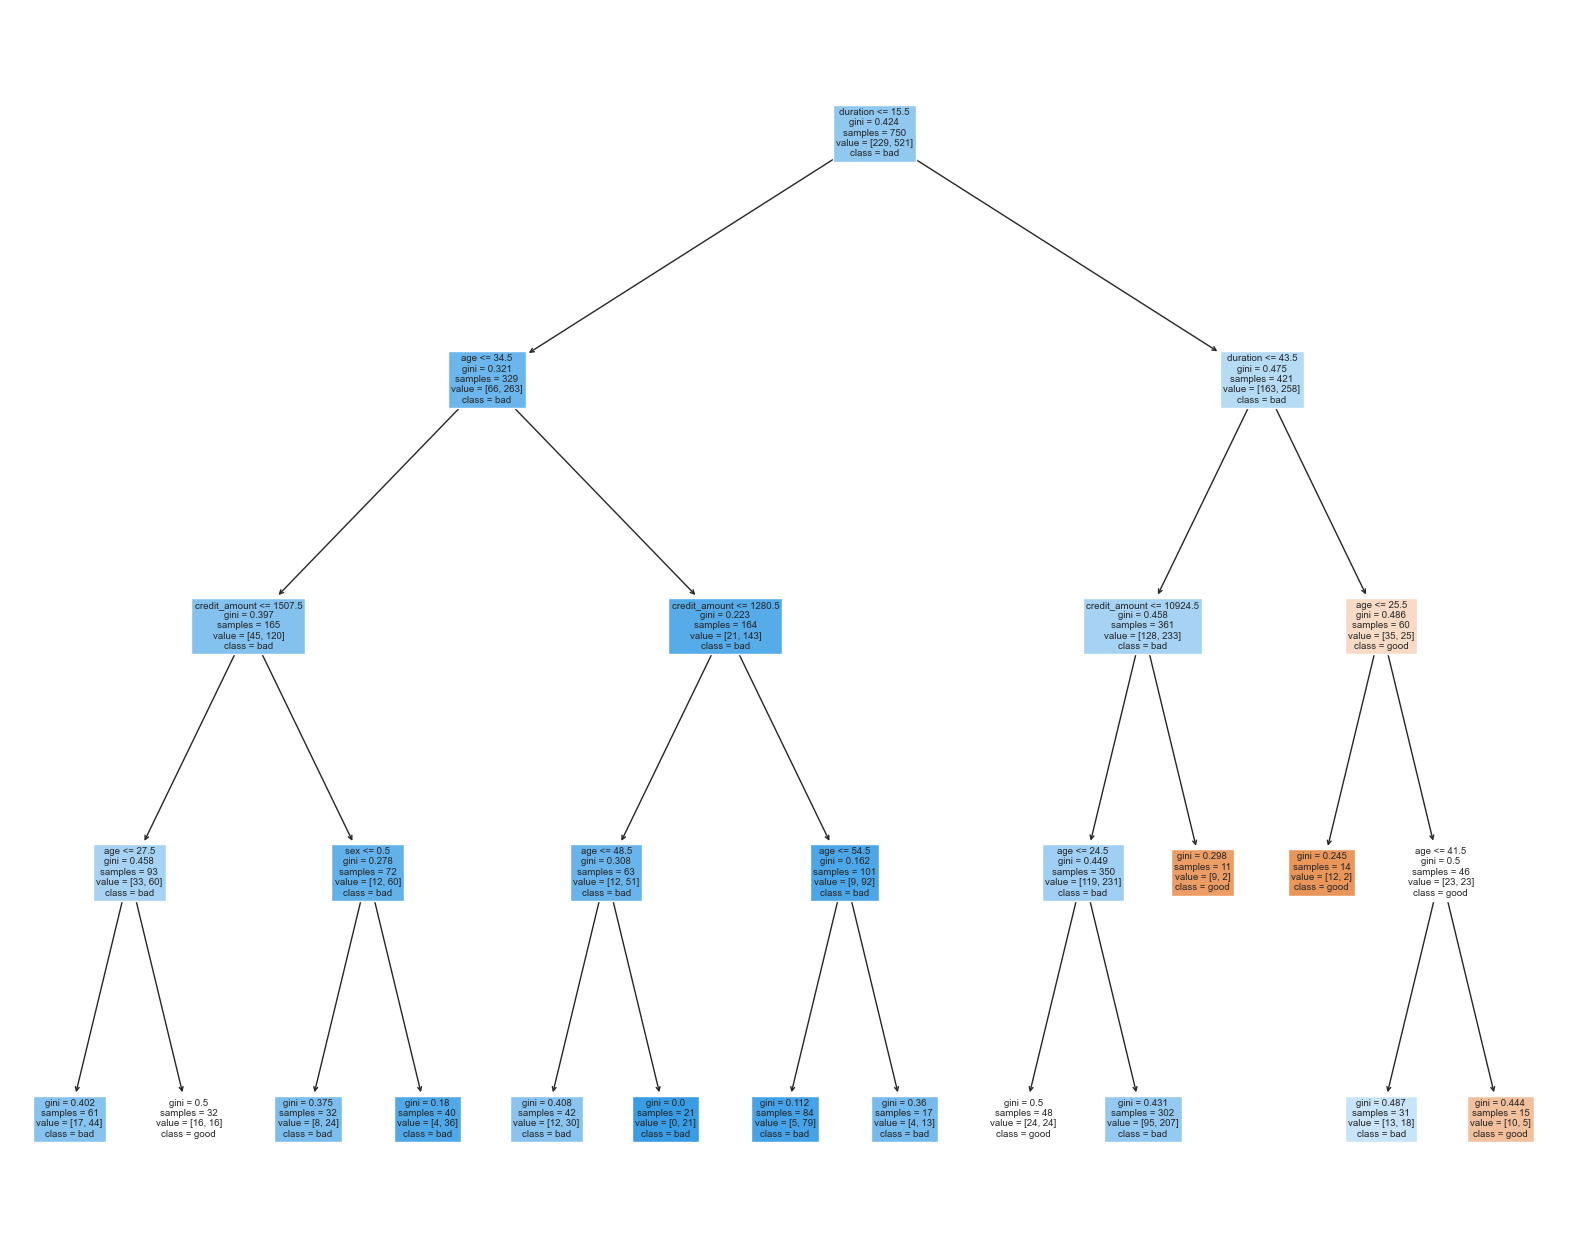

In [262]:
plt.figure(figsize=(20,16))

plot_tree(tree_clf2, feature_names=labels_col, class_names=df['class'].values,filled=True);

Jak widzimy na samym szczycie drzewa mamy "duration", które jest najistotniejszym czynnikiem przy podziale danych.

In [263]:
importances_sk = tree_clf2.feature_importances_

In [264]:
pd.DataFrame(importances_sk, labels_col)

,0
duration,0.423510
credit_amount,0.198473
age,0.359442
sex,0.018574


Co ciekawe, okazuje się, że największy wpływ na klasyfikacją miał tu okres kredytu, potem kwota, wiek. Płeć nie została wzięta pod uwagę, co można oznaczać, że słabo dzieliła dane. 

              precision    recall  f1-score   support

           0       0.39      0.17      0.24        71
           1       0.73      0.89      0.80       179

    accuracy                           0.69       250
   macro avg       0.56      0.53      0.52       250
weighted avg       0.63      0.69      0.64       250



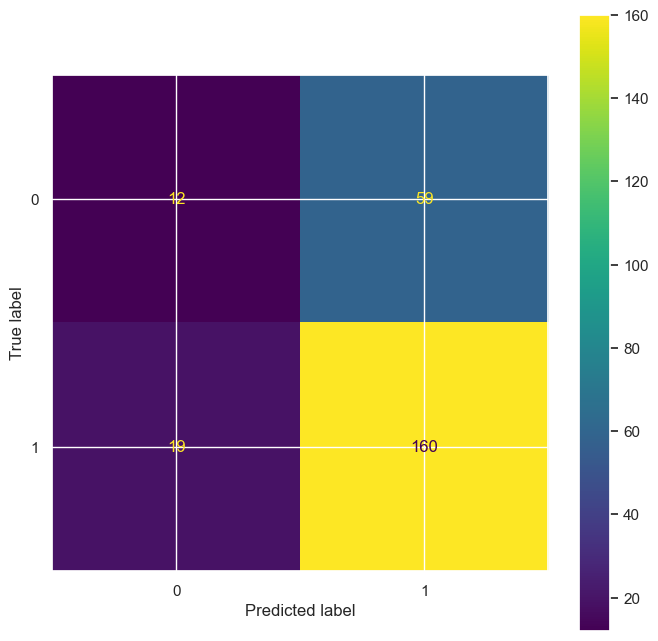

In [265]:
y_pred2 = tree_clf2.predict(X_test)
cm = confusion_matrix(y_test, y_pred2)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(classification_report(y_test, y_pred2))

W przypadku drzewa decyzyjnego mamy bardzo podobne wyniki jak w przypadku regresji logistycznej. Różnica jest minimalna na niekorzyść drzewa decyzyjnego - recall, precision i accuracy są odrobinę niższe.

<h3>Który model jest lepszy w przypadku tego zbioru danych?</h3>  

  
Trudno jednoznacznie odpowiedzieć na to pytanie, ponieważ oba modele miały niemalże takie same wyniki, czyli po odpowiednim dobraniu parametrów poradziły sobie prawie tak samo (czyli dosyć przeciętnie). Jeśli chodzi o łatwość w interpretacji, to nie ma większej różnicy między nimi. Warto jednak zaznaczyć, że drzewo decyzyjne wymagało znacznego przycięcia, żeby uniknąć overfittingu, co nie było problemem w przypadku regresji logistycznej. W przypadku drzewa decyzyjnego jednoznacznie było widoczne, które zmienne miały wpływ na scoring, a które nie, co nie było jasne w przypadku regresji. Model regresji logistycznej lepiej poradził sobie w klasyfikowaniu klasy, która była mniej licznie reprezentowana w zbiorze niż drzewo decyzyjne. Wydaje mi się, że oba modele są odpowiednimi modelami do klasyfikacji.

